# Weapon impact

Correlation between main weapon used and various "features" of the round on different maps

## Parameters

In [81]:
from s2_analytics.constants import WEAPON_MODS_DATES

CHART_MAX_WIDTH = 10
CHART_HEIGHT_PER_ENTRY = 0.3

MINIMUM_SAMPLES = 30
MAX_WIN_PROB_DIFF = 0.20
START_DATE=WEAPON_MODS_DATES[0]
PLAYLISTS=["CTF-Standard-6"]

print(f"Start date: {START_DATE}")
print(f"Playlists: {','.join(PLAYLISTS)}")
print()
print(f"Min samples: {MINIMUM_SAMPLES}")
print(f"Max match imbalance: {MAX_WIN_PROB_DIFF * 100:.0f}%")


Start date: 2022-12-28 00:00:00
Playlists: CTF-Standard-6

Min samples: 30
Max match imbalance: 20%


In [82]:
from pandas import DataFrame

from s2_analytics.filters import max_imbalance
import sqlite3

import pandas as pd
import seaborn as sns

from s2_analytics.collector.sqlite_collector import SqliteCollector
from s2_analytics.constants import WEAPONS_PRIMARY
from s2_analytics.importer import import_games
from s2_analytics.main_weapon_analyzer import MainWeaponRoundTagger
from s2_analytics.team_round_tag_correlation_analyzer import TeamRoundTagCorrelationAnalyzer
from s2_analytics.test_summary_collector import SummaryCollector

conn = sqlite3.connect("file::memory:")
sqlite_collector = SqliteCollector(sqlite_conn=conn).init()
summary_collector = SummaryCollector(conn, sqlite_collector)
tag_correlation_analyzer = TeamRoundTagCorrelationAnalyzer(conn, sqlite_collector, [
    MainWeaponRoundTagger([WEAPONS_PRIMARY])]).init()
import_games(
    "logs_ranked/",
    start_date=START_DATE,
    # period_days=99999,
    processors=[tag_correlation_analyzer, sqlite_collector],
    game_filters=[
        lambda g: g.playlist_code in ["CTF-Standard-6"],
        max_imbalance(MAX_WIN_PROB_DIFF)
    ]
)
pass

## Data summary

In [83]:
import tabulate

summary = summary_collector.get_summary().to_table()
tabulate.tabulate(summary, tablefmt='html')

First game,2022-12-28
Last game,2023-02-03
Games total,260
Rounds total,675
Games in playlist `CTF-Standard-6`,260


## Aggregated result

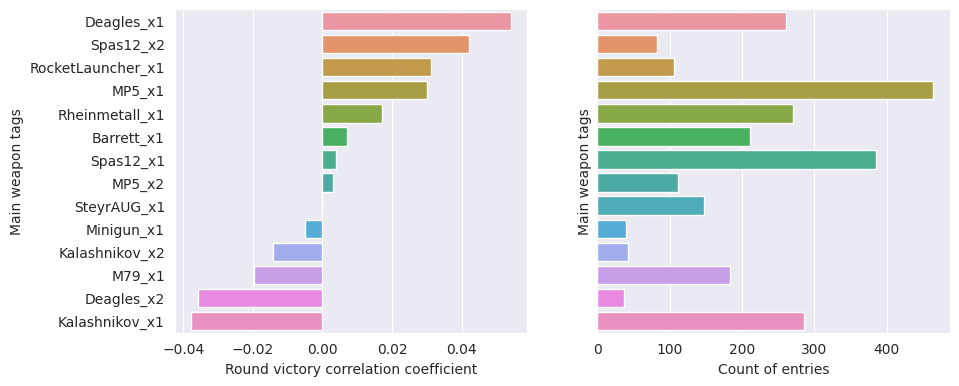

In [84]:
from matplotlib import pyplot as plt
from s2_analytics.test_main_weapon_analyzer import NO_RESULT_TAG_FILTER

correlation_per_map = tag_correlation_analyzer.calculate_win_correlation()


correlation_df = pd.DataFrame(correlation_per_map.items(), columns=["tag", "corr"])
counts_df = pd.DataFrame(
    tag_correlation_analyzer.tag_counts(NO_RESULT_TAG_FILTER).items(),
    columns=["tag", "cnt"])

df = pd.merge(correlation_df, counts_df, on=["tag"])


def filter_and_sort_for_corr_charts(df: DataFrame, min_samples, limit):
    df["corr_abs"] = df['corr'].abs()
    df = df[df.apply(lambda x: x["cnt"] > min_samples, axis=1)]
    return df.sort_values("corr_abs", ascending=False) \
        .head(n=limit) \
        .sort_values("corr", ascending=False)


df = filter_and_sort_for_corr_charts(df, MINIMUM_SAMPLES, 15)

fig, axes = plt.subplots(1, 2, figsize=(CHART_MAX_WIDTH, len(df["corr"]) * CHART_HEIGHT_PER_ENTRY), sharey=True)
sns.barplot(x=df["corr"], y=df["tag"], ax=axes[0]) \
    .set(xlabel="Round victory correlation coefficient", ylabel="Main weapon tags")
sns.barplot(x=df["cnt"], y=df["tag"], ax=axes[1]) \
    .set(xlabel="Count of entries", ylabel="Main weapon tags")
pass

## Each map separately

Not enough samples for 22 maps


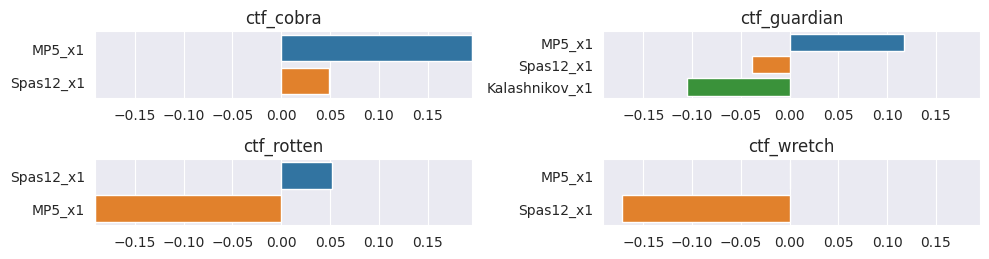

In [87]:
from math import ceil

correlation_per_map = tag_correlation_analyzer.calculate_win_correlation_per_map()
counts_per_map = tag_correlation_analyzer.tag_counts_per_map(NO_RESULT_TAG_FILTER)


def correlation_for_map(correlations: DataFrame, counts: DataFrame):
    df = pd.merge(
        on=["tag"],
        left=pd.DataFrame(correlations.items(), columns=["tag", "corr"]),
        right=pd.DataFrame(counts.items(), columns=["tag", "cnt"]))
    return df


max_corr = 0
min_corr = 0
total_entries = 0
charts = []
not_enough_data = []
for map in sorted(list(counts_per_map.keys())):
    correlations = correlation_per_map[map]
    counts = counts_per_map[map]
    df1 = pd.merge(on=["tag"],
                   left=pd.DataFrame(correlations.items(), columns=["tag", "corr"]),
                   right=pd.DataFrame(counts.items(), columns=["tag", "cnt"]))
    df = df1
    df = filter_and_sort_for_corr_charts(df, min_samples=(MINIMUM_SAMPLES), limit=5)
    entries_count = len(df["corr"])
    total_entries += entries_count
    if entries_count > 0:
        charts.append((map, df))
        df_max = df["corr"].max()
        if df_max > max_corr:
            max_corr = df_max
        df_min = df["corr"].min()
        if df_min < min_corr:
            min_corr = df_min
    else:
        not_enough_data.append(map)

nrows = ceil(len(charts) / 2)
fig, axes = plt.subplots(nrows, 2, figsize=(CHART_MAX_WIDTH, total_entries/len(charts) * nrows * 0.6), tight_layout=True)
axes = axes.flatten()
print(f"Not enough samples for {len(not_enough_data)} maps")

for i, chart_data in enumerate(charts):
    map, df = chart_data
    axes[i].set(xlabel=None, ylabel=None)
    axes[i].set(xlim=(min_corr, max_corr))
    sns.barplot(x=df["corr"], y=df["tag"], ax=axes[i]) \
        .set(title=map, xlabel=None, ylabel=None)

pass